In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from playsound import playsound as play

%matplotlib inline

In [2]:
# This is the algorithm for computing DTFT of given signal
# The parameters for this Algorithm is a signal of shape (2, N) or  (N, )
# it has some default parameters like lower limit, higher limit and Number of points for omega axis

def dtft(signal, low_lim=-1*np.pi, high_lim=np.pi, N=100, endpoints=False):
    w = np.linspace(low_lim, high_lim, N, endpoint=endpoints)                  #Array of omega values
    e_jw = np.exp(w*1j)                                                    #computes e^{jw}
    
    # Creates a dictnationry to store dtft, Magnitude, Phase and omega
    dtft = dict()        
    # Creates a empty array for dtft
    dtft['complex'] = np.zeros(N, dtype=complex) 
    # Assiging omega values 
    dtft['omega'] = w
    
    # The following conditional statements are for checking whether the input(signal) is been provided with 
    # time stamps
    if signal.ndim == 2:
        for i in range(signal.shape[1]):
            dtft['complex'] += signal[0, i]*np.power(e_jw, -1*signal[1, i])
    else:
        for i in range(signal.shape[0]):
            dtft['complex'] += signal[i]*np.power(e_jw, -1*i)

    # Rounds-off the result upto 4 decimal places
    dtft['complex'] = np.round(dtft['complex'], decimals=4)
    # Finds the magnitude of the dtft computed above.
    dtft['magnitude'] = np.absolute(dtft['complex'])
    # Finds the phase of dtft in radians which lies in the range[-pi, pi]
    dtft['phase'] = np.angle(dtft['complex'], deg=0)
    return dtft

# This function is used for plotting Real part, Imaginary part, Magnitude and Phase for a given DTFT

def dtft_plotter(dtft, title=None, complex_part=True):
    plt.rcParams['figure.figsize'] = [10, 8]
    
    if complex_part:
        fig, ax = plt.subplots(2,2)

        if title != None:
            fig.suptitle(title, fontweight="bold")

        ax[0, 0].title.set_text('Real Part')
        ax[0, 0].stem(dtft['omega'], np.real(dtft['complex']))
        ax[0, 0].set(ylabel='$Re\{X(e^{j \omega})\}$')

        ax[0, 1].title.set_text('Imaginary Part')
        ax[0, 1].stem(dtft['omega'], np.imag(dtft['complex']), 'tab:red')
        ax[0, 1].yaxis.tick_right()
        ax[0, 1].set(ylabel='$Im\{X(e^{j \omega})\}$')

        ax[1, 0].title.set_text('Magnitude')
        ax[1, 0].stem(dtft['omega'], dtft['magnitude'], 'tab:orange')
        ax[1, 0].set(xlabel='$\omega$', ylabel='$|X(e^{j \omega})|$')

        ax[1, 1].title.set_text('Phase')
        ax[1, 1].stem(dtft['omega'], dtft['phase'], 'tab:green')
        ax[1, 1].yaxis.tick_right()        
        ax[1, 1].set(xlabel='$\omega$', ylabel='$\phi$(in radians)')
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.stem(dtft['omega'],dtft['magnitude'])
        ax1.set(xlabel='$\omega$', ylabel='$X(e^{j \omega})$')
        ax1.title.set_text('Magnitude')

        ax2.stem(dtft['omega'],dtft['phase'], 'tab:green')
        ax2.plot(xlabel = 'n', ylabel=r'$\phi$(in radians)')
        ax2.title.set_text('Phase')

#This function computes covolution between two signals and if required plots them
def convolve(x, h, n_x=None, plot=True, N=100):
    n  =  x.shape[0]
    m = h.shape[0]
    h = np.flip(h)
    pads = np.zeros(m-1)
    X =  np.hstack((pads, x, pads))
    y = np.array([np.dot(X[i:i+m], h) for i in range(n+m-1)])
    nY = y.shape[0]
    if plot:
        px = np.hstack((x, np.zeros(nY-n)))
        if n%2 ==1:
            N = np.hstack((n_x, np.array([(n-1)/2+i for i in range(nY-n)])))
        else:
            N = np.hstack((n_x, np.array([n/2+i for i in range(nY-n)])))
        plt.rcParams['figure.figsize'] = [10, 8]
        plt.rc('axes', labelsize=12)

        fig, (ax1,ax2) = plt.subplots(2, 1)
        ax1.stem(N, px)
        ax1.set(xlabel='n', ylabel='x[n]')
        ax2.stem(N, y)
        ax2.set(xlabel='n', ylabel='y[n]')
    
    return y

#This fuction computes group delay for a given phase. This is acheived by numerical differentiation so due to its
#limitaions there might appear some spikes in 
def group_delay(phi, w):
    grd = []
    for i in range(1, len(phi)-1):
        grd.append((phi[i+1] - phi[i-1])/(w[i-1] - w[i+1]))
    grd = np.array(grd)
    return grd

[1.         2.57877308 3.4975     2.50736971 1.265625  ]


<ipython-input-6-c04deca885b7>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  h = h.astype(np.float64)


<StemContainer object of 3 artists>

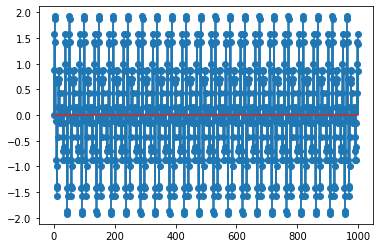

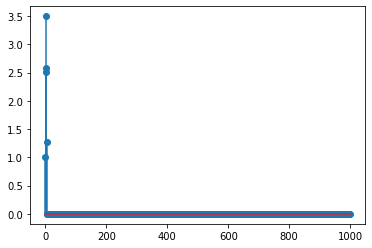

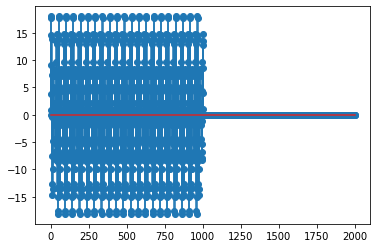

In [6]:
def distortionfilter_gen(zeros):
    p4 = zeros[0]*zeros[1]*zeros[2]*zeros[3]
    p3 = p4*(1/zeros[0]+1/zeros[1]+1/zeros[2]+1/zeros[3])
    p2 = zeros[0]*zeros[1] + zeros[0]*zeros[2] + zeros[0]*zeros[3]+ zeros[1]*zeros[2] + zeros[1]*zeros[3]+ zeros[2]*zeros[3]
    p1 = zeros[0]+zeros[1]+zeros[2]+zeros[3]
    
    return np.array([1, -1*p1, p2, -1*p3, p4])
#h[n] = d[n] - 17.2078j*d[n-1] -93.832*d[n-2] + 187.353j*d[n-3] + 123.283*d[n-4]
# h = np.array([1, -17.2078j, -93.832, 187.353j, 123.283])
# h = np.array([1.265625, 
#               -0.9*1.25*(1.8*np.cos(0.8*np.pi) + 2.5*np.cos(0.6*np.pi)), 
#               0.9**2 + 1.25**2 + 2*0.9*1.25*(np.cos(0.2*np.pi)+np.cos(1.4*np.pi))
#               ,-1.8*np.cos(0.6*np.pi)-2.5*np.cos(0.8*np.pi)
#               ,1])
# h = np.flip(h)
h=distortionfilter_gen([0.9*np.exp(0.6j*np.pi), 0.9*np.exp(-0.6j*np.pi), 1.25*np.exp(0.8j*np.pi), 1.25*np.exp(-0.8j*np.pi)])
h = h.astype(np.float64)
N = 1000
print(h)
h = np.hstack((h, np.zeros(N-len(h))))
n = np.linspace(0, N, N+1)
x = np.sin(np.pi*n/6) + np.sin(np.pi*n/8)

y = convolve(x, h, plot=False)
plt.figure()
plt.stem(n, x)

plt.figure()
plt.stem(h)

plt.figure()
plt.stem(y)

[ 6.40000000e-01 -1.18442098e+00  8.03157902e-01 ... -3.52098486e-47
  1.43428032e-46 -5.12590816e-47]


<StemContainer object of 3 artists>

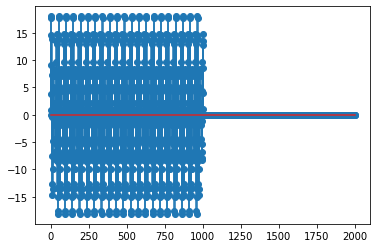

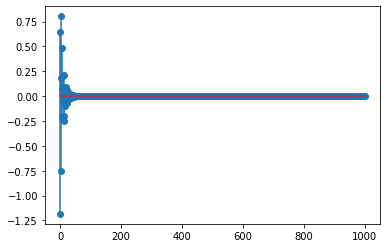

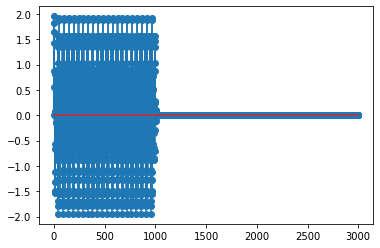

In [7]:
def partialfrac_coef(z, i):
    coe = 0
    if i==1:
        coe = 1/((1-0.9*np.exp(-0.6j*np.pi)/z)*(1-1.25*np.exp(0.8j*np.pi)/z)*(1-0.8*np.exp(-0.8j*np.pi)/z))
    
    elif i==2:
        coe = 1/((1-0.9*np.exp(0.6j*np.pi)/z)*(1-1.25*np.exp(0.8j*np.pi)/z)*(1-0.8*np.exp(-0.8j*np.pi)/z))
    elif i==3:
        coe = 1/((1-0.9*np.exp(0.6j*np.pi)/z)*(1-0.9*np.exp(-0.6j*np.pi)/z)*(1-0.8*np.exp(-0.8j*np.pi)/z))
    elif i==4:
        coe = 1/((1-0.9*np.exp(0.6j*np.pi)/z)*(1-0.9*np.exp(-0.6j*np.pi)/z)*(1-0.8*np.exp(0.8j*np.pi)/z))
    return coe
# g = np.array([0.5184, 
#               -0.9*(1.8*np.cos(0.8*np.pi) + 1.6*np.cos(0.6*np.pi))/1.25, 
#               0.9**2 + 1.25**(-2) + 2*0.9*(np.cos(0.2*np.pi)+np.cos(1.4*np.pi))/1.25
#               ,-1.8*np.cos(0.6*np.pi)-1.6*np.cos(0.8*np.pi)
#               ,1])
# g = np.flip(g)*1.25*1.25
g = -1*np.power((- 0.27811529493745262842097076827486 - 0.8559508646656383001882772987301j),n)*(0.14663288710561474694866337150187 + 0.34062336288391083028618212680458j) - np.power((- 0.27811529493745262842097076827486 + 0.8559508646656383001882772987301j), n)*(0.14663288710561474694866337150187 - 0.34062336288391083028618212680458j) + np.power((- 0.64721359549995793880583505597315 - 0.47022820183397862070506789677893j), n)*(0.46663288710561474694866337150187 - 0.083838714358561967363412760930737j) + np.power((- 0.64721359549995793880583505597315 + 0.47022820183397862070506789677893j), n)*(0.46663288710561474694866337150187 + 0.083838714358561967363412760930737j)
# pi = np.pi
# g = 0.8*0.8*(partialfrac_coef(0.9*np.exp(0.6j*pi), 1)*np.power(0.9*np.exp(0.6j*pi), n) + partialfrac_coef(0.9*np.exp(-0.6j*pi), 2)*np.power(0.9*np.exp(-0.6j*pi), n)+partialfrac_coef(0.8*np.exp(0.8j*pi), 3)*np.power(0.8*np.exp(0.8j*pi), n)+partialfrac_coef(0.8*np.exp(-0.8j*pi), 4)*np.power(0.8*np.exp(-0.8j*pi), n))
g = np.real(g)
print(g)
xt = convolve(y, g, plot=False)
plt.figure()
plt.stem(y)

plt.figure()
plt.stem(g)

plt.figure()
plt.stem(xt)

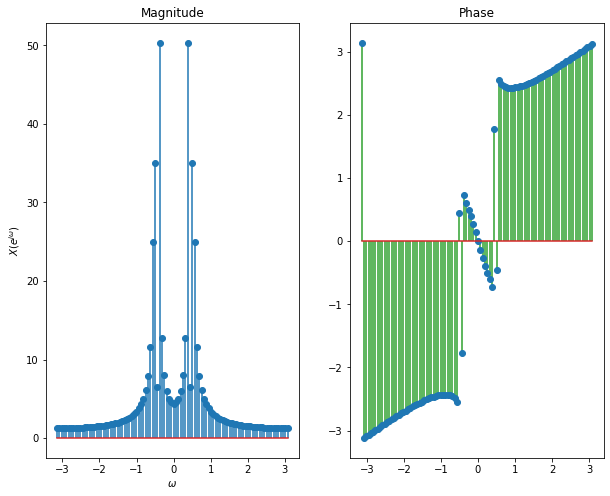

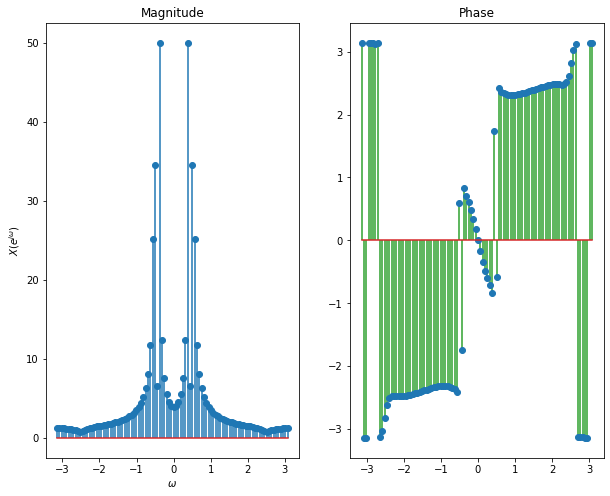

In [8]:
dtft_plotter(dtft(x[:100]), complex_part=False)
dtft_plotter(dtft(xt[:100]), complex_part=False)

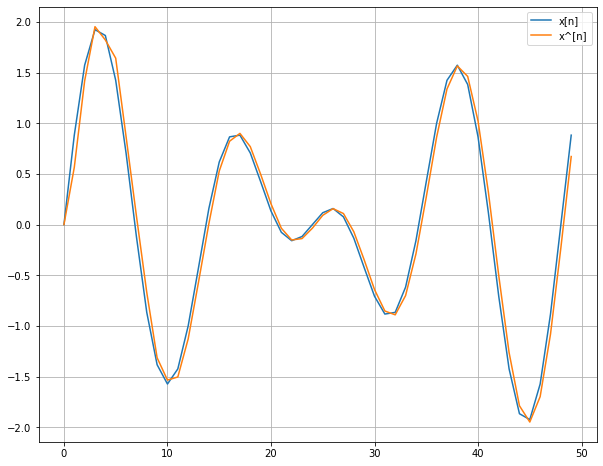

In [9]:
plt.plot(x[:50], label='x[n]')
plt.plot(xt[:50], label='x^[n]')
plt.grid()
plt.legend(loc=1)

(0.0, 2.0)

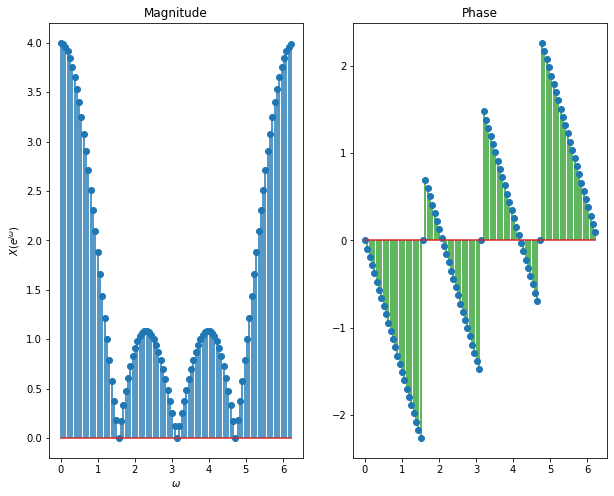

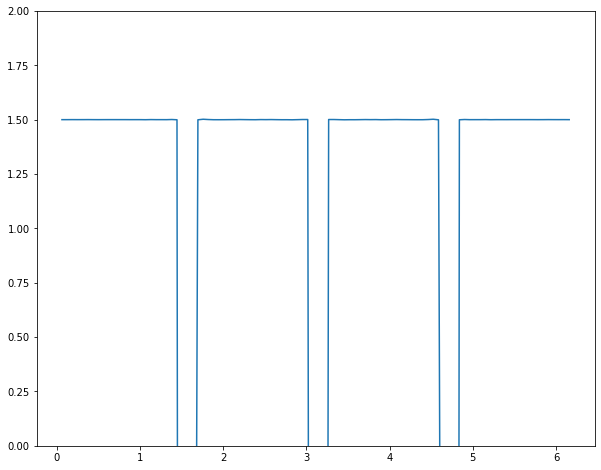

In [39]:
h = np.array([1, 1, 1, 1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)
dtft_plotter(H, complex_part=False)
plt.figure()
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 2))

(0.0, 2.0)

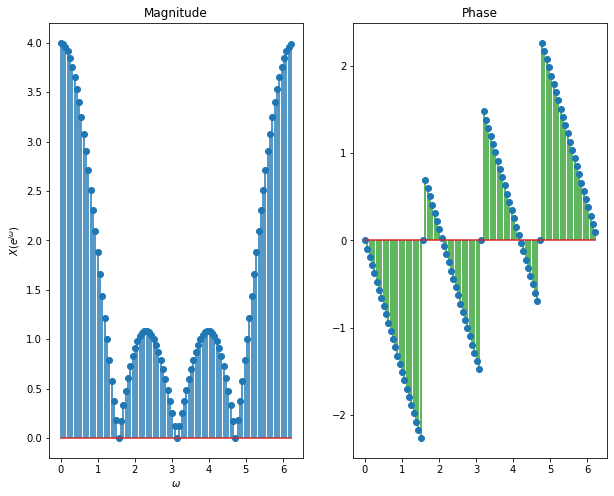

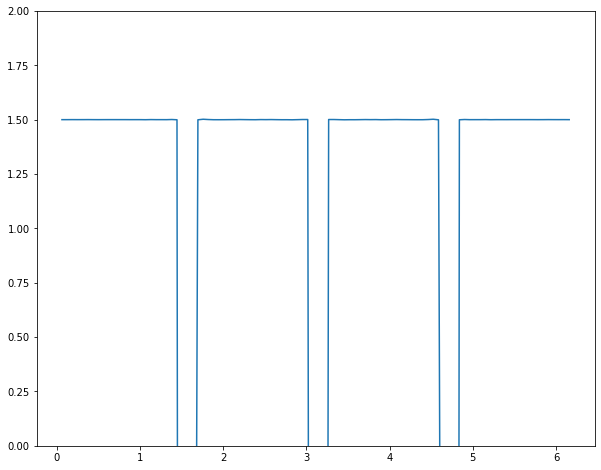

In [9]:
h = np.array([1, 1, 1, 1, ])

H = dtft(h, low_lim=0, high_lim=2*np.pi)
dtft_plotter(H, complex_part=False)
plt.figure()
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 2))

(0.0, 2.0)

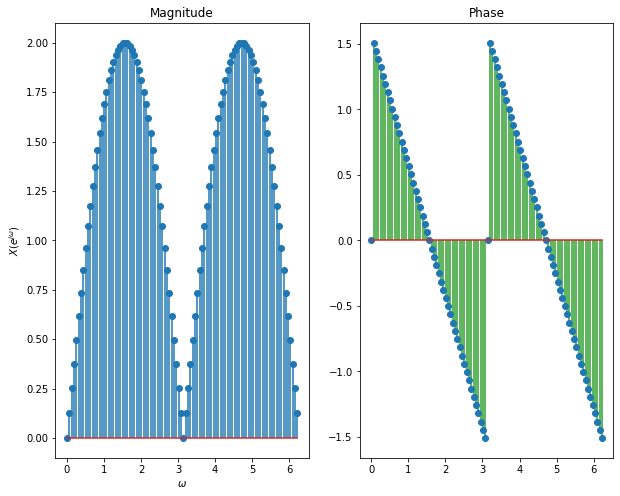

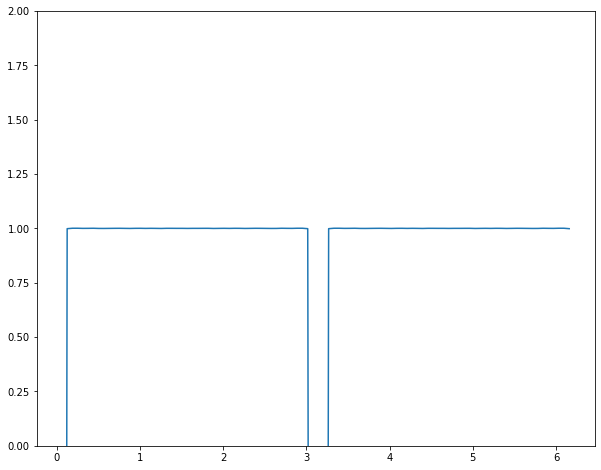

In [10]:
h = np.array([1, 0,-1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)
dtft_plotter(H, complex_part=False)
plt.figure()
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 2))

(0.0, 2.0)

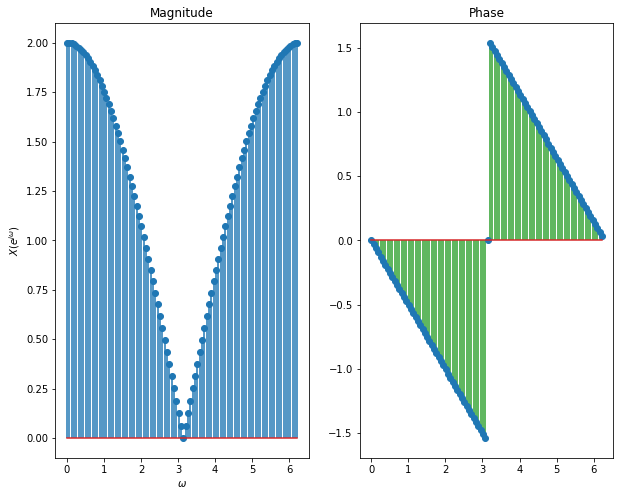

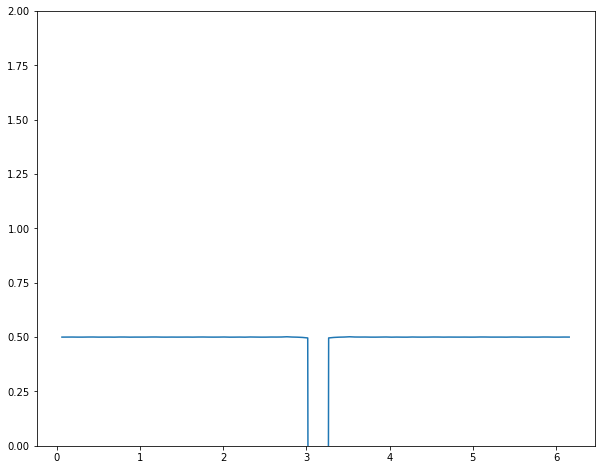

In [40]:
h = np.array([1, 1])

H = dtft(h, low_lim=0, high_lim=2*np.pi)
dtft_plotter(H, complex_part=False)
plt.figure()
plt.plot(H['omega'][1:-1], group_delay(H['phase'], H['omega']))
plt.ylim((0, 2))